# Timeseries API Examples

This notebook shows a few simple examples of retrieving data using the [Timeseries](https://docs.climateengine.com/docs/build/html/timeseries.html) family of endpoints.  This group of endpoints are used to retrieve time series data for datasets in Climate Engine, including interannual and regression analysis. 

The CE API token is read as an environment variable named `CE_API_KEY`.

Climate Engine \
October 2021

In [1]:
from calendar import month_abbr
import json
import os
import requests

from folium import Map, GeoJson
import folium
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

In [2]:
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

In [3]:
# Set root URL for API requests
root_url = 'https://geodata.dri.edu/'

In [4]:
# Authentication info
headers = {'Authorization': os.getenv('CE_API_KEY')}

## Native Values - Landsat NDVI

In this example, the /timeseries/native/custom_asset endpoint is used to collect averaged Landsat NDVI values for a group of four agricultural fields in the western US during the year 2020.  The field polygons are retrieved from Google Earth Engine as a custom feature collection asset.  All Landsat NDVI observations inside these polygons for the year 2020 are collected; multiple observations inside each field at the same time are averaged together.  The NDVI trajectories for each field are plotted together, which shows clear cutting cycles for each field.

Detailed documentation for the timeseries/native/custom_asset endpoint found [here](https://docs.climateengine.com/docs/build/html/timeseries.html#timeseries-native-custom-asset).

In [5]:
# Endpoint
endpoint = 'timeseries/native/custom_asset'

In [6]:
# Extract field polygon coordinates from GeoJSON
# These are the fields in the Earth Engine feature collection
field_poly_json = r'example_fields.geojson'
with open(field_poly_json, 'r') as f:
    field_polygon_dict = json.load(f)
field_polygon_coords = field_polygon_dict['features'][0]['geometry']['coordinates']

In [7]:
# Map field outlines
m = Map(
    width='100%', 
    height='100%',
    location=[39.7197, -115.9642],
    zoom_start=14,
    tiles=None
)

# Add satellite basemap
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)


style = {'fillColor': 'None', 'color': '#ff00ff'}
GeoJson(data=field_polygon_dict, name='Agricultural Fields', style_function=lambda x:style).add_to(m)
m

In [8]:
# Set up parameters for API call
ndvi_params = {
    'dataset': 'LANDSAT_SR',
    'variable': 'NDVI',
    'start_date': '2020-01-01' ,
    'end_date': '2020-12-31',  
    'asset_id': 'users/thomas_work_projects/ce_api_examples/field_example',
    'area_reducer': 'mean',
    'filter_by': 'polygon_id'
}

In [9]:
# Send request to the API
r = requests.get(root_url + endpoint, params=ndvi_params, headers=headers, verify=False)
response = r.json()

In [10]:
# Convert to dataframe
ndvi_df = pd.DataFrame()
for ts_id in response:
    df = pd.DataFrame(ts_id)
    ndvi_df = ndvi_df.append(df)

# Convert to datetime and remove no data observations
ndvi_df["Date"] = pd.to_datetime(ndvi_df["Date"])
ndvi_df = ndvi_df.replace(-9999, np.nan).dropna()

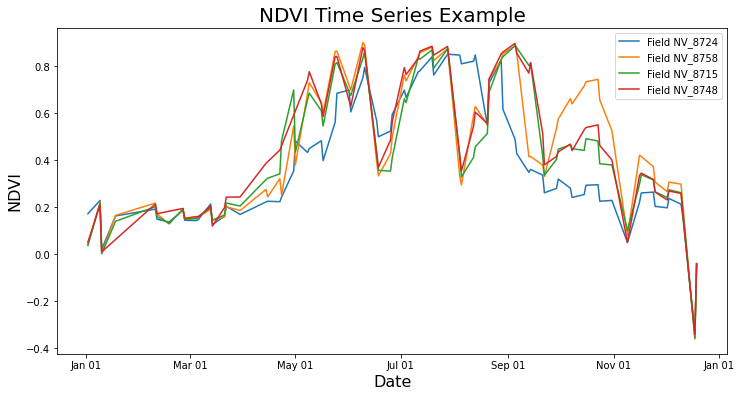

In [11]:
# Plot all four fields together
plt.figure(figsize=(12,6))
for field_id in ndvi_df["polygon_id"].unique():
    field_df = ndvi_df.loc[ndvi_df.polygon_id == field_id]
    plt.plot(field_df["Date"], field_df["NDVI"], label=f'Field {field_id}')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xlabel('Date', fontsize=16)
plt.ylabel('NDVI', fontsize=16)
plt.title(f'NDVI Time Series Example', fontsize=20)
plt.legend(loc='best')
plt.show()

## Interannual Values - NDVI and Precipitation

In this example, the /timeseries/interannual/custom_asset endpoint is used to generate Landsat NDVI and gridMET precipitation difference from average staistics for a meadow in the Sierra Nevada.  This region exists as a custom feature in a Google Earth Engine feature collection. 

We use this endpoint to extract spatial and temporal statistics for a given set of months over a year range.  In the following example, we compare the average NDVI for a given meadow in the Sierra Nevada from Apr-Aug with the corresponding precipiation totals in the same region from Feb-May.  Plotting the NDVI and precipitation interannual amounts together shows the meadow's relationship between summertime NDVI and springtime precipitation.

Detailed documentation for the timeseries/interannual/custom_asset endpoint found [here](https://docs.climateengine.com/docs/build/html/timeseries.html#timeseries-interannual-custom-asset).

In [12]:
# Endpoint for the interannual analysis
endpoint = 'timeseries/interannual/custom_asset'

In [13]:
# Extract polygon coordinates from GeoJSON
sierra_json = r'ClimateEngine_US_Sierra_Meadows_3586.geojson'
with open(sierra_json, 'r') as f:
    sierra_polygon_dict = json.load(f)
sierra_polygon_coords = sierra_polygon_dict['features'][0]['geometry']['coordinates']

In [14]:
# Map field outline
m2 = Map(
    width='100%', 
    height='100%',
    location=sierra_polygon_coords[0][10][::-1],
    zoom_start=16,
    tiles=None
)

# Add satellite basemap
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m2)


style = {'fillColor': 'None', 'color': '#ff00ff'}
GeoJson(data=sierra_polygon_dict, name='Sierra Meadow', style_function=lambda x:style).add_to(m2)
m2

In [15]:
# Build the params dictionary for the Landsat NDVI query
# We're spatially averaging over the polygon and temporally averaging over the
# specified start and end month and day (Apr 1 to Aug 1) for each year in the range
sierra_ndvi_params = {
    'dataset': 'LANDSAT_SR',
    'variable': 'NDVI',
    'temporal_statistic': 'mean',
    'start_day': 1,
    'end_day': 1,
    'start_month': 4,
    'end_month': 8,
    'start_year': 2000,
    'end_year': 2021,
    'asset_id': 'users/thomas_work_projects/ce_api_examples/ClimateEngine_US_Sierra_Meadows_3586',
    'area_reducer': 'mean',
    'filter_by': 'Name'
}

# Send request to the API
r = requests.get(root_url + endpoint, params=sierra_ndvi_params, headers=headers, verify=False)
sierra_ndvi_response = r.json()

# Convert to dataframe
sierra_ndvi_df = pd.DataFrame()
for ts_id in sierra_ndvi_response:
    df = pd.DataFrame(ts_id)
    sierra_ndvi_df = sierra_ndvi_df.append(df)

In [16]:
# Build the params dictionary for the gridMET precipitation query
# We're spatially averaging over the polygon and temporally summing over the 
# specified start and end month and day (Jan 1 to Apr 1) for each year in the range
sierra_precip_params = {
    'dataset': 'G',
    'variable': 'pr',
    'temporal_statistic': 'total',
    'start_day': 1,
    'end_day': 1,
    'start_month': 2,
    'end_month': 5,
    'start_year': 2000,
    'end_year': 2021,
    'asset_id': 'users/thomas_work_projects/ce_api_examples/ClimateEngine_US_Sierra_Meadows_3586',
    'area_reducer': 'mean',
    'filter_by': 'Name'
}

# Send request to the API
r = requests.get(root_url + endpoint, params=sierra_precip_params, headers=headers, verify=False)
sierra_precip_response = r.json()

# Convert to dataframe
sierra_precip_df = pd.DataFrame()
for ts_id in sierra_precip_response:
    df = pd.DataFrame(ts_id)
    sierra_precip_df = sierra_precip_df.append(df)

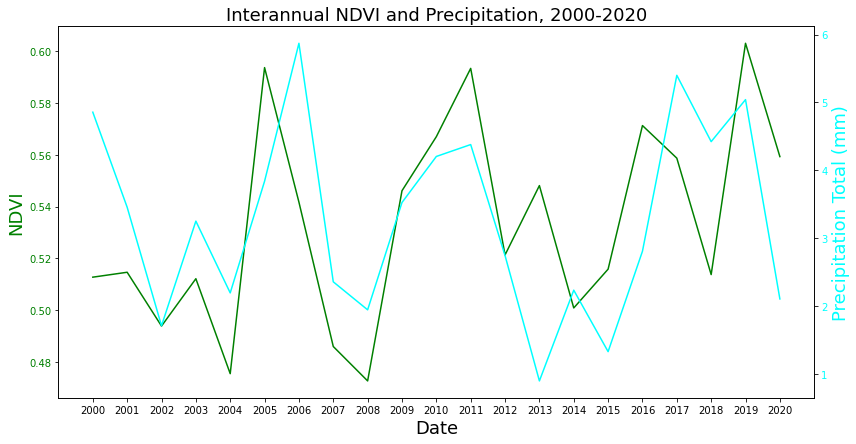

In [17]:
# Plot the interannual NDVI and precipitation data together
fig, ax1 = plt.subplots(figsize=(12, 6))
ndvi_color = 'green'
ax1.set_xlabel('Date', fontsize=18)
ax1.set_ylabel('NDVI', color=ndvi_color, fontsize=18)
ax1.plot(sierra_ndvi_df["Date"], sierra_ndvi_df["NDVI"], color=ndvi_color)
ax1.tick_params(axis='y', labelcolor=ndvi_color)
ax2 = ax1.twinx()  
precip_color = 'cyan'
ax2.set_ylabel('Precipitation Total (mm)', color=precip_color, fontsize=18) 
ax2.plot(sierra_precip_df["Date"], sierra_precip_df["pr (mm)"], color=precip_color)
ax2.tick_params(axis='y', labelcolor=precip_color)
fig.tight_layout()
plt.title('Interannual NDVI and Precipitation, 2000-2020', fontsize=18)
plt.show()